# Übung 20 - AE_GAN

## Autoencoder

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model

In [2]:
# Eingabedimension
input_dim = 784

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

# Decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder-Modell
autoencoder = Model(input_layer, decoded)

In [3]:
# Modell kompilieren
autoencoder.compile(optimizer='adam', loss='mse')

In [5]:
# Beispiel mit MNIST-Datensatz
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), input_dim))
x_test = x_test.reshape((len(x_test), input_dim))

autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - val_loss: 0.0085


In [6]:
# Rekonstruierte Daten
reconstructed_data = autoencoder.predict(x_test)

# Extrahierte Merkmale
encoder = Model(input_layer, encoded)
encoded_data = encoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


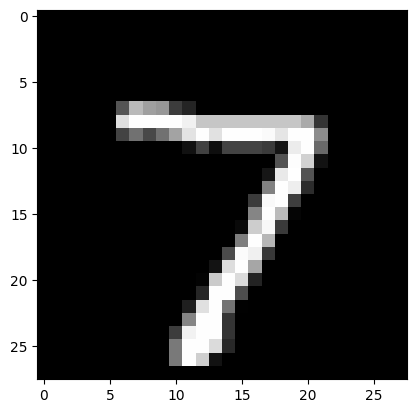

In [9]:
# Den ersten Datenpunkt aus x_text visualisieren
import matplotlib.pyplot as plt
plt.imshow(x_test[0].reshape(28, 28), cmap='gray')
plt.show()

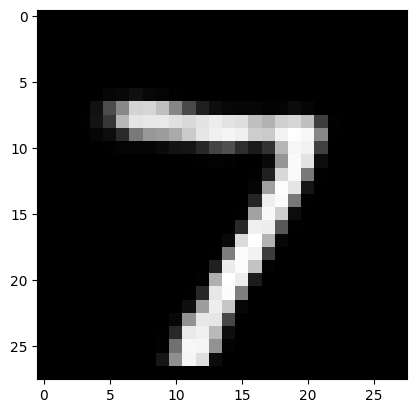

In [8]:
# Den ersten Datenpunkt aus reconstructed_data visualisieren
import matplotlib.pyplot as plt
plt.imshow(reconstructed_data[0].reshape(28, 28), cmap='gray')
plt.show()

In [10]:
# encoded data vom 1. Datenpunkt anschauen
print(encoded_data[0])

[ 9.317028   0.        12.368433   5.817658  10.835703   0.
 16.766514   0.        19.183699  10.245862   0.         7.3895106
 14.157505   4.966873  10.610646  21.151445  16.038368   0.
  0.        19.049643   0.        12.959346  11.966504  14.325654
  7.715472  28.762129   8.483869  12.995801  13.1121435 22.57648
  9.76166   24.978052 ]


In [13]:
print(x_test[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

## Generative Adversarial Network

In [1]:
# notwendige Libraries importieren
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import numpy as np

In [2]:
# Generator konfigurieren
def build_generator(latent_dim, img_shape):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    return model

In [3]:
# Diskriminator konfigurieren
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [4]:
# GAN erstellen und kompilieren
# Bilddimensionen
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

# Latenter Raum Dimension
latent_dim = 100

# Optimierer
optimizer = Adam(0.0002, 0.5)

# Diskriminator erstellen und kompilieren
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

# Generator erstellen
generator = build_generator(latent_dim, img_shape)

# Generator-Eingabe (Rauschen)
z = Input(shape=(latent_dim,))
img = generator(z)

# Diskriminator während des Generator-Trainings nicht trainieren
discriminator.trainable = False

# Gültigkeit des generierten Bildes durch den Diskriminator
validity = discriminator(img)

# Kombiniertes GAN-Modell (Generator + Diskriminator)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# GAN trainieren
# Trainingsparameter
epochs = 500
batch_size = 128
sample_interval = 20

# MNIST-Datensatz laden
(X_train, _), (_, _) = keras.datasets.mnist.load_data()

# Daten vorverarbeiten
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

# Gültige und ungültige Labels
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# Trainingsschleife
for epoch in range(epochs):

    # ---------------------
    #  Diskriminator trainieren
    # ---------------------

    # Batch mit echten Bildern auswählen
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Rauschen erzeugen und Bilder generieren
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(noise)

    # Diskriminator auf echten und generierten Bildern trainieren
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Generator trainieren
    # ---------------------

    # Rauschen erzeugen
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Generator trainieren, um den Diskriminator zu täuschen
    g_loss = combined.train_on_batch(noise, valid)

    # Fortschritt ausgeben
    if epoch % sample_interval == 0:
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss_real[0], 100*d_loss_real[1], g_loss[0]))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.477849, acc.: 92.97%] [G loss: 0.688767]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
20 [D loss: 2.295449, acc.: 46.95%] [G loss: 2.385310]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


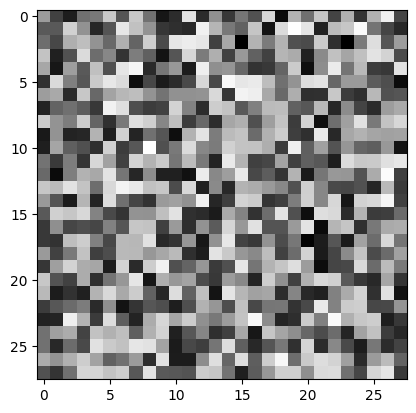

In [6]:
import matplotlib.pyplot as plt

# Beispielbild generieren
noise = np.random.normal(0, 1, (batch_size, latent_dim))
gen_imgs = generator.predict(noise)

# Das generierte Bild als tatsächliches Bild darstellen
plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')
plt.show()
